# Repouso - Heart Rate Estimation

**Objetivo:** Prever frequência cardíaca (HR) a partir de sinais PPG e acelerômetro.

Dados disponíveis:
- PPG: Sinal fotopletismografia (volume de sangue)
- Acelerômetro: 3 eixos (X, Y, Z) - para remover artefatos de movimento
- HR ground truth: Apenas nas fases 0, 2 e 4 (treino/validação)

## Parameters and Loading Data

In [8]:
# ============================================================
# GLOBAL CONFIGURATION — EDA PIPELINE (PHASE 4 | EXERCISE)
# ============================================================

from pathlib import Path
import numpy as np
import os

# ------------------------------------------------------------
# 1. PROJECT ROOT (estrutura confirmada)
# ------------------------------------------------------------
PROJECT_ROOT = Path(
    "/Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimationMAC"
)

assert PROJECT_ROOT.exists(), f"❌ Project root não encontrado: {PROJECT_ROOT}"

# ------------------------------------------------------------
# 2. RAW DATA
# ------------------------------------------------------------
DATA_PATH = PROJECT_ROOT / "data" / "raw" / "mhealth24_data_public.npy"

if not DATA_PATH.exists():
    raise FileNotFoundError(f"❌ Arquivo RAW não encontrado: {DATA_PATH}")

# ------------------------------------------------------------
# 3. WINDOWING PARAMETERS
# ------------------------------------------------------------
FS = 128
WINDOW_SEC = 30
WINDOW_SIZE = FS * WINDOW_SEC  # 3840 samples

PHASE_NAME = "phase 4"
PHASE_ID = 4
PHASE_MAP = {PHASE_NAME: PHASE_ID}

# ------------------------------------------------------------
# 4. OUTPUT DIRECTORIES — EXERCISE
# ------------------------------------------------------------
WINDOW_OUT_DIR = (
    PROJECT_ROOT
    / "exercicio"
    / "data"
    / "processed"
    / "janelas_30s_clean"
)

EDA_DIR = (
    PROJECT_ROOT
    / "exercicio"
    / "eda"
)

PROCESSED_DIR = (
    PROJECT_ROOT
    / "exercicio"
    / "data"
    / "processed"
)

WINDOW_OUT_DIR.mkdir(parents=True, exist_ok=True)
EDA_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------------
# 5. SANITY CHECK
# ------------------------------------------------------------
print("=== GLOBAL CONFIGURATION LOADED (PHASE 4 — EXERCISE) ===")
print(f"→ Project root:          {PROJECT_ROOT}")
print(f"→ Raw data path:         {DATA_PATH}")
print(f"→ Window size:           {WINDOW_SIZE} samples ({WINDOW_SEC}s @ {FS}Hz)")
print(f"→ Phase:                 {PHASE_NAME} ({PHASE_ID})")
print(f"→ Windows output dir:    {WINDOW_OUT_DIR}")
print(f"→ EDA output dir:        {EDA_DIR}")
print("=======================================================")

=== GLOBAL CONFIGURATION LOADED (PHASE 4 — EXERCISE) ===
→ Project root:          /Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimationMAC
→ Raw data path:         /Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimationMAC/data/raw/mhealth24_data_public.npy
→ Window size:           3840 samples (30s @ 128Hz)
→ Phase:                 phase 4 (4)
→ Windows output dir:    /Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimationMAC/exercicio/data/processed/janelas_30s_clean
→ EDA output dir:        /Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimationMAC/exercicio/eda


In [9]:
# ============================================================
# CÉLULA 1 — Leitura do arquivo RAW
# ============================================================
import numpy as np
import os

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Arquivo não encontrado: {DATA_PATH}")

print(f"📥 Carregando arquivo RAW: {DATA_PATH}")
data = np.load(DATA_PATH, allow_pickle=True).item()

print("✅ Base carregada com sucesso!")
print("📌 Fases detectadas:", list(data.keys()))

📥 Carregando arquivo RAW: /Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimationMAC/data/raw/mhealth24_data_public.npy
✅ Base carregada com sucesso!
📌 Fases detectadas: ['phase 0', 'phase 1', 'phase 2', 'phase 3', 'phase 4', 'phase 5']


## Windowing Procedure for phase 4

	1.	Identifies relevant channels from the dataset dictionary:
	     - PPG
	     - IMU X, IMU Y, IMU Z
	     - Ground-truth HR

	2.	Validates signal lengths to ensure all sensors are aligned.

	3.	Splits the continuous signals into non-overlapping windows of 3840 samples.

	4.	Stacks the four channels (PPG + 3 IMU axes) into a (3840 × 4) matrix per window.

	5.	Extracts:
	    - X_raw: windowed sensor data
	    - y_raw: HR values aligned by window
	    - Id_raw: unique window identifier
	    - phase_raw: numeric phase labels

	6.	Optionally saves all arrays to disk for downstream Feature Engineering and model training.

This step transforms the continuous physiological recordings into a unified dataset of structured windows, which is the foundation for the entire feature extraction and ML pipeline.

In [11]:
# ============================================================
# EDA Exercise — Windowing da Phase 4
# ============================================================

import numpy as np
import os

# ------------------------------------------------------------
# Utils
# ------------------------------------------------------------
def find_key(d, contains):
    if isinstance(contains, str):
        contains = [contains]
    for k in d.keys():
        kl = k.lower().strip()
        if all(t in kl for t in contains):
            return k
    return None


def find_all(d, contains):
    if isinstance(contains, str):
        contains = [contains]
    return [k for k in d.keys() if all(t in k.lower().strip() for t in contains)]


# ------------------------------------------------------------
# Windowing — Phase 4
# ------------------------------------------------------------
def create_windows_from_phase(
    phase_dict,
    *,
    phase_name,
    phase_id,
    window_size,
    window_sec
):
    """
    Cria janelas de tamanho fixo contendo:
        X  → (N, window_size, 4)   [PPG, IMU_X, IMU_Y, IMU_Z]
        y  → HR verdadeiro por janela
        Id → identificador único
    """

    # --- Identificar chaves ---
    ppg_key = find_key(phase_dict, "ppg")
    imu_keys = sorted(find_all(phase_dict, "imu"))
    hr_key = find_key(phase_dict, ["ground", "hr"])

    if ppg_key is None or hr_key is None or len(imu_keys) < 3:
        raise KeyError(
            f"[{phase_name}] Chaves inválidas — "
            f"PPG: {ppg_key}, IMU: {imu_keys}, HR: {hr_key}"
        )

    # --- Ler vetores ---
    ppg = np.asarray(phase_dict[ppg_key])
    imu_x = np.asarray(phase_dict[imu_keys[0]])
    imu_y = np.asarray(phase_dict[imu_keys[1]])
    imu_z = np.asarray(phase_dict[imu_keys[2]])
    hr = np.asarray(phase_dict[hr_key])

    # --- Alinhamento ---
    lengths = [len(ppg), len(imu_x), len(imu_y), len(imu_z)]
    if len(set(lengths)) != 1:
        raise ValueError(f"[{phase_name}] PPG e IMU com tamanhos diferentes: {lengths}")

    total_samples = len(ppg)
    num_windows = total_samples // window_size

    print(f"   → {phase_name}: {num_windows} janelas ({window_sec}s cada)")

    X_list, y_list, Id_list = [], [], []

    for w in range(num_windows):
        start = w * window_size
        end = start + window_size

        Xw = np.stack(
            [ppg[start:end], imu_x[start:end], imu_y[start:end], imu_z[start:end]],
            axis=1
        )

        X_list.append(Xw)
        y_list.append(float(hr[w]))
        Id_list.append(int(f"{phase_id:01d}{w:06d}"))

    return (
        np.asarray(X_list),
        np.asarray(y_list, dtype=float),
        np.asarray(Id_list, dtype=np.int64)
    )


def load_windows_phase_4_from_data(data, *, out_dir, save=True):
    print("📦 Dataset carregado na memória.")
    print("Fases encontradas:", list(data.keys()))

    phase_name = "phase 4"
    phase_id = PHASE_MAP[phase_name]

    if phase_name not in data:
        raise KeyError("❌ Phase 4 não encontrada no dataset")

    print("\n==============================")
    print("🔍 WINDOWING — PHASE 4 (EXERCISE)")
    print("==============================")

    X_raw, y_raw, Id_raw = create_windows_from_phase(
        data[phase_name],
        phase_name=phase_name,
        phase_id=phase_id,
        window_size=WINDOW_SIZE,
        window_sec=WINDOW_SEC,
    )

    phase_raw = np.full(len(X_raw), phase_id, dtype=int)

    print("\n==============================")
    print("📦 SHAPES FINAIS (Phase 4)")
    print("==============================")
    print("X_raw:", X_raw.shape)
    print("y_raw:", y_raw.shape)
    print("Id_raw:", Id_raw.shape)
    print("phase_raw:", phase_raw.shape)

    if save:
        np.save(out_dir / "X.npy", X_raw)
        np.save(out_dir / "y.npy", y_raw)
        np.save(out_dir / "Id.npy", Id_raw)
        np.save(out_dir / "phase.npy", phase_raw)
        print(f"\n💾 Arquivos salvos em: {out_dir}")

    return X_raw, y_raw, Id_raw, phase_raw

In [12]:
# ============================================================
# EXECUÇÃO DO WINDOWING — PHASE 4 (EXERCISE)
# ============================================================

print("🚀 Executando windowing da Phase 4 (exercise)...")

X_raw, y_raw, Id_raw, phase_raw = load_windows_phase_4_from_data(
    data,
    out_dir=WINDOW_OUT_DIR,
    save=True
)

print("\n✅ Windowing concluído!")
print(f"X_raw shape:      {X_raw.shape}")
print(f"y_raw shape:      {y_raw.shape}")
print(f"Id_raw shape:     {Id_raw.shape}")
print(f"phase_raw shape:  {phase_raw.shape}")

print("\n🔎 PHASE GUARD")
print("Unique phases:", np.unique(phase_raw))

assert set(np.unique(phase_raw)) == {4}, "❌ Dataset não é Phase 4"
assert X_raw.shape[0] < 200, "❌ Volume incompatível com Phase 4"

print("✅ Contexto Phase 4 confirmado")

🚀 Executando windowing da Phase 4 (exercise)...
📦 Dataset carregado na memória.
Fases encontradas: ['phase 0', 'phase 1', 'phase 2', 'phase 3', 'phase 4', 'phase 5']

🔍 WINDOWING — PHASE 4 (EXERCISE)
   → phase 4: 57 janelas (30s cada)

📦 SHAPES FINAIS (Phase 4)
X_raw: (57, 3840, 4)
y_raw: (57,)
Id_raw: (57,)
phase_raw: (57,)

💾 Arquivos salvos em: /Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimationMAC/exercicio/data/processed/janelas_30s_clean

✅ Windowing concluído!
X_raw shape:      (57, 3840, 4)
y_raw shape:      (57,)
Id_raw shape:     (57,)
phase_raw shape:  (57,)

🔎 PHASE GUARD
Unique phases: [4]
✅ Contexto Phase 4 confirmado


## Statistic — Basic Feature Extraction

O objetivo da FASE 2 é gerar todas as features estatísticas básicas para cada janela:

- PPG: mean, std, min, max, range
- IMU magnitude: mean, std, p95, energy
- metadados: Id, phase, window (contador local), hr_true

In [31]:
# ============================================================
# PHASE 2 — BASIC FEATURE EXTRACTION (UNIFICADA)
# ============================================================

import os
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# Função principal: calcula as features por janela
# ------------------------------------------------------------
def extract_basic_features(X_raw, y_raw, Id_raw, phase_raw):
    """
    Extrai features estatísticas básicas para cada janela de 30s.

    Inputs:
        X_raw:      (N, 3840, 4)  → [PPG, IMU_X, IMU_Y, IMU_Z]
        y_raw:      (N,)          → HR verdadeiro
        Id_raw:     (N,)          → IDs únicos por janela
        phase_raw:  (N,)          → números das fases (0 ou 2)

    Output:
        df_basic: DataFrame com uma linha por janela contendo:
            Id, phase, window, hr_true,
            ppg_mean, ppg_std, ppg_min, ppg_max, ppg_range,
            imu_mean, imu_std, imu_p95, imu_energy
    """
    N = X_raw.shape[0]

    # --- Separa canais ---
    ppg = X_raw[:, :, 0]                      # (N, 3840)
    imu_xyz = X_raw[:, :, 1:]                 # (N, 3840, 3)
    imu_mag = np.linalg.norm(imu_xyz, axis=2) # magnitude → (N, 3840)

    # --- Features de PPG ---
    ppg_mean  = ppg.mean(axis=1)
    ppg_std   = ppg.std(axis=1)
    ppg_min   = ppg.min(axis=1)
    ppg_max   = ppg.max(axis=1)
    ppg_range = ppg_max - ppg_min

    # --- Features de IMU ---
    imu_mean   = imu_mag.mean(axis=1)
    imu_std    = imu_mag.std(axis=1)
    imu_p95    = np.percentile(imu_mag, 95, axis=1)
    imu_energy = np.sum(imu_mag ** 2, axis=1)

    # --- Índice da janela dentro da fase ---
    window = Id_raw % 1_000_000

    # --- Construção do DataFrame ---
    df_basic = pd.DataFrame({
        "Id": Id_raw,
        "phase": phase_raw,
        "window": window,
        "hr_true": y_raw,

        "ppg_mean": ppg_mean,
        "ppg_std": ppg_std,
        "ppg_min": ppg_min,
        "ppg_max": ppg_max,
        "ppg_range": ppg_range,

        "imu_mean": imu_mean,
        "imu_std": imu_std,
        "imu_p95": imu_p95,
        "imu_energy": imu_energy,
    })

    return df_basic


# ------------------------------------------------------------
# Execução da Fase 2
# ------------------------------------------------------------

print("🔄 Rodando PHASE 2 — Basic Feature Extraction...")

df_basic = extract_basic_features(X_raw, y_raw, Id_raw, phase_raw)

print("✅ PHASE 2 — Concluída!")
print("Shape:", df_basic.shape)
display(df_basic.head())


# ------------------------------------------------------------
# Salvamento — usando o diretório global EDA_DIR
# ------------------------------------------------------------

os.makedirs(EDA_DIR, exist_ok=True)

OUTPUT_CSV = os.path.join(EDA_DIR, "fase2_basic_features.txt")
df_basic.to_csv(OUTPUT_CSV, index=False)

print(f"\n💾 Basic features salvos em:\n{OUTPUT_CSV}")

🔄 Rodando PHASE 2 — Basic Feature Extraction...
✅ PHASE 2 — Concluída!
Shape: (792, 13)


,Id,phase,window,hr_true,ppg_mean,ppg_std,ppg_min,ppg_max,ppg_range,imu_mean,imu_std,imu_p95,imu_energy
0,0,0,0,73.161689,78810.324219,60.054215,78579,79005,426,492.589193,2.634623,496.713197,9.317800e+08
1,1,0,1,71.234783,145673.590365,66718.852211,75929,376198,300269,509.592135,124.952525,699.767095,1.057142e+09
2,2,0,2,80.025260,242593.535156,13830.388278,213558,275854,62296,496.866754,107.252759,687.920778,9.921781e+08
3,3,0,3,85.547201,233831.187760,8087.142454,221095,266312,45217,480.165296,63.490273,578.692141,9.008245e+08
4,4,0,4,84.420017,215936.016927,12703.394206,190699,264698,73999,496.085531,108.061979,667.067855,9.898685e+08



💾 Basic features salvos em:
/Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimation/repouso/eda/fase2_basic_features.txt


## Statistic — Advanced Feature Extraction

Objetivo

Transformar cada janela (30s) de PPG + IMU em um conjunto de features fisiológicas e espectrais avançadas, trazendo:

	- Indicadores de qualidade do sinal
	- Energia em bandas fisiológicas
	- Coerência entre PPG e IMU (movimento → ruído)
	- Medidas de entropia (complexidade do sinal)
	- Espectros via Welch
	- Estimativas iniciais de HR (hr_candidate)
	- Features de fusão PPG × IMU
	- Indicadores de movimento (jerk, RMS)

É uma camada acima da Phase 2 (estatísticas simples), permitindo que modelos fiquem mais:

	- robustos
	- interpretáveis
	- sensíveis ao contexto fisiológico real

In [32]:
# ============================================================
#                   PHASE 3 — ADVANCED FEATURES
#   PPG + IMU + Welch + Bandpower + Coherence + Entropy + SQI
#   + HR Candidate + RMS (acc_rms)
# ============================================================

import numpy as np
import pandas as pd
from scipy import signal
from scipy.stats import entropy


# ------------------------------------------------------------
# Usa parâmetros globais definidos no Global Config Cell:
#   FS, WIN_SEC, WINDOW_SIZE
# ------------------------------------------------------------

N = WINDOW_SIZE   # 3840 samples por janela (vindo do Config)


# ============================================================
# Utility Functions
# ============================================================

def welch_psd(x, fs=FS):
    """Compute PSD using Welch method."""
    freqs, psd = signal.welch(
        x,
        fs=fs,
        nperseg=1024,
        noverlap=512,
        window="hann",
        scaling="density"
    )
    return freqs, psd


def bandpower(freqs, psd, fmin, fmax):
    """Computa potência no intervalo [fmin, fmax]."""
    mask = (freqs >= fmin) & (freqs <= fmax)
    if np.sum(mask) == 0:
        return 0.0
    return np.trapz(psd[mask], freqs[mask])


def compute_jerk(x):
    """Jerk = derivada da magnitude ACC."""
    dx = np.diff(x)
    return np.mean(np.abs(dx)), np.std(dx)


def compute_coherence(ppg, imu_mag, fs=FS):
    try:
        f, Cxy = signal.coherence(ppg, imu_mag, fs=fs, nperseg=1024)
        mask = (f >= 0.7) & (f <= 3.5)
        return np.nanmean(Cxy[mask])
    except Exception:
        return np.nan


def compute_sqi(ppg):
    """Signal Quality Index baseado em bandpower cardíaco."""
    freqs, psd = welch_psd(ppg)
    bp_hr = bandpower(freqs, psd, 0.7, 3.5)
    bp_total = bandpower(freqs, psd, 0.1, 10)
    if bp_total == 0:
        return np.nan
    return bp_hr / (bp_total + 1e-9)


def compute_hr_candidate(ppg_window, imu_window, fs=FS):
    """
    HR estimation via Welch peak + motion-aware harmonic correction.
    """
    imu_mag = np.sqrt(np.sum(imu_window**2, axis=1))
    imu_std = np.std(imu_mag)

    freqs, psd = signal.welch(
        ppg_window,
        fs=fs,
        nperseg=1024,
        noverlap=512
    )

    mask = (freqs >= 0.7) & (freqs <= 3.5)
    freqs_hr = freqs[mask]
    psd_hr = psd[mask]

    if len(psd_hr) == 0:
        return np.nan

    f_peak = freqs_hr[np.argmax(psd_hr)]
    hr_est = f_peak * 60

    # Correções harmônicas dependendo de movimento
    if hr_est < 100 and imu_std > 2.5:
        hr_est *= 2
    elif hr_est < 80 and imu_std > 4.0:
        hr_est *= 3

    return float(np.clip(hr_est, 80, 200))


# ============================================================
# MAIN EXTRACTOR — Integrated with df_basic
# ============================================================

def extract_advanced_features(X_raw, df_basic):
    """
    Inputs:
        X_raw:   (N, WINDOW_SIZE, 4)
        df_basic: dataframe com features básicas

    Output:
        df_all = df_basic + advanced features
    """
    advanced_rows = []

    for i in range(len(X_raw)):
        window = X_raw[i]
        ppg = window[:, 0]
        imu_xyz = window[:, 1:]
        imu_mag = np.sqrt(np.sum(imu_xyz**2, axis=1))

        row = {}

        # ----------------------------------------
        # 0) RMS — indicador global de movimento
        # ----------------------------------------
        row["acc_rms"] = np.sqrt(np.mean(imu_mag**2))

        # ----------------------------------------
        # 1) Welch PPG
        # ----------------------------------------
        freqs, psd = welch_psd(ppg)

        row["ppg_bp_low"]  = bandpower(freqs, psd, 0.1, 0.7)
        row["ppg_bp_hr"]   = bandpower(freqs, psd, 0.7, 3.5)
        row["ppg_bp_high"] = bandpower(freqs, psd, 3.5, 10)

        bp_total = row["ppg_bp_low"] + row["ppg_bp_hr"] + row["ppg_bp_high"] + 1e-9
        row["ppg_bp_hr_norm"] = row["ppg_bp_hr"] / bp_total

        hr_mask = (freqs >= 0.7) & (freqs <= 3.5)
        row["ppg_f_dom"] = freqs[hr_mask][np.argmax(psd[hr_mask])]

        # ----------------------------------------
        # 2) Welch IMU
        # ----------------------------------------
        fi, psdi = welch_psd(imu_mag)
        row["imu_bp_low"]  = bandpower(fi, psdi, 0.1, 1.0)
        row["imu_bp_high"] = bandpower(fi, psdi, 1.0, 10)

        # ----------------------------------------
        # 3) Jerk
        # ----------------------------------------
        row["imu_jerk_mean"], row["imu_jerk_std"] = compute_jerk(imu_mag)

        # ----------------------------------------
        # 4) Coherence
        # ----------------------------------------
        row["coherence_ppg_imu"] = compute_coherence(ppg, imu_mag)

        # ----------------------------------------
        # 5) Entropy
        # ----------------------------------------
        hist_ppg, _ = np.histogram(ppg, bins=32, density=True)
        row["ppg_entropy"] = entropy(hist_ppg + 1e-9)

        hist_imu, _ = np.histogram(imu_mag, bins=32, density=True)
        row["imu_entropy"] = entropy(hist_imu + 1e-9)

        # ----------------------------------------
        # 6) SQI
        # ----------------------------------------
        row["sqi"] = compute_sqi(ppg)

        # ----------------------------------------
        # 7) Fusion Feature
        # ----------------------------------------
        row["fusion_ppg_imu"] = row["ppg_bp_hr_norm"] * (1 + row["imu_bp_high"])

        # ----------------------------------------
        # 8) HR candidate
        # ----------------------------------------
        row["hr_candidate"] = compute_hr_candidate(ppg, imu_xyz)

        advanced_rows.append(row)

        if (i + 1) % 200 == 0:
            print(f"   → {i+1}/{len(X_raw)} windows processed")

    df_adv = pd.DataFrame(advanced_rows)

    # Merge limpo com df_basic
    df_all = pd.concat([
        df_basic.reset_index(drop=True),
        df_adv.reset_index(drop=True)
    ], axis=1)

    return df_all

In [37]:
# ============================================================
# FASE 3 — Advanced Feature Extraction + Save to Drive
# ============================================================

import os

# ------------------------------------------------------------
# Caminhos já definidos nos parâmetros globais:
#   EDA_DIR
# ------------------------------------------------------------

OUTPUT_CSV = os.path.join(EDA_DIR, "fase3_advanced_features.txt")

# ------------------------------------------------------------
# Rodando a Fase 3 (usa X_raw e df_basic já na memória)
# ------------------------------------------------------------

print("⏳ Rodando FASE 3 — Advanced Features...")

df_all = extract_advanced_features(
    X_raw=X_raw,
    df_basic=df_basic
)

print("✅ PHASE 3 — Advanced features completed.")
print("Shape:", df_all.shape)
display(df_all.head())

# ------------------------------------------------------------
# Salvar resultado da fase 3
# ------------------------------------------------------------

df_all.to_csv(OUTPUT_CSV, index=False)
print(f"💾 Advanced features salvos em:\n{OUTPUT_CSV}")

⏳ Rodando FASE 3 — Advanced Features...
   → 200/792 windows processed
   → 400/792 windows processed
   → 600/792 windows processed
✅ PHASE 3 — Advanced features completed.
Shape: (792, 29)


,Id,phase,window,hr_true,ppg_mean,ppg_std,ppg_min,ppg_max,ppg_range,imu_mean,...,imu_bp_low,imu_bp_high,imu_jerk_mean,imu_jerk_std,coherence_ppg_imu,ppg_entropy,imu_entropy,sqi,fusion_ppg_imu,hr_candidate
0,0,0,0,73.161689,78810.324219,60.054215,78579,79005,426,492.589193,...,0.124754,1.044232,2.916252,3.641280,0.192635,2.920798,2.802252,0.284913,0.595162,150.0
1,1,0,1,71.234783,145673.590365,66718.852211,75929,376198,300269,509.592135,...,1338.104149,6847.490664,46.829814,105.492925,0.135010,2.372987,1.594476,0.452694,3395.242051,90.0
2,2,0,2,80.025260,242593.535156,13830.388278,213558,275854,62296,496.866754,...,3676.559528,8362.625098,20.532285,49.421346,0.163853,3.215173,1.905520,0.203134,1736.875884,135.0
3,3,0,3,85.547201,233831.187760,8087.142454,221095,266312,45217,480.165296,...,485.798585,2289.948785,13.893279,23.137944,0.310269,2.688575,1.974962,0.176775,436.807717,90.0
4,4,0,4,84.420017,215936.016927,12703.394206,190699,264698,73999,496.085531,...,2197.447327,9757.217305,27.738442,41.555290,0.203091,3.029870,2.500981,0.220527,2289.623022,90.0


💾 Advanced features salvos em:
/Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimation/repouso/eda/fase3_advanced_features.txt


## Phase 4 — Full Statistical EDA Summary

This cell performs a complete statistical exploration of the dataset after
basic and advanced feature extraction. It analyzes feature relationships,
signal quality, errors, and cluster structure to help understand how the
model may behave during training.

**The analysis includes:**
- **Correlation analysis (Pearson & Spearman):** identifies the features most related to `hr_true`.
- **PCA (2D projection):** visualizes how samples distribute across phases in a reduced feature space.
- **Motion vs HR error analysis:** evaluates how movement intensity affects HR estimation.
- **ANOVA tests:** checks whether HR and HR error differ significantly across phases and motion levels.
- **Signal Quality Index (SQI) statistics:** highlights the proportion of low-quality windows.
- **K-Means clustering:** identifies natural groupings of windows using PCA components.

Finally, the processed dataset `df_all` is saved to the *processed* folder
to be used in the next notebook for Feature Engineering, splitting, and training.

=== FASE 4 — EDA ESTATÍSTICA ===
(792, 29)
Index(['Id', 'phase', 'window', 'hr_true', 'ppg_mean', 'ppg_std', 'ppg_min',
       'ppg_max', 'ppg_range', 'imu_mean', 'imu_std', 'imu_p95', 'imu_energy',
       'acc_rms', 'ppg_bp_low', 'ppg_bp_hr', 'ppg_bp_high', 'ppg_bp_hr_norm',
       'ppg_f_dom', 'imu_bp_low', 'imu_bp_high', 'imu_jerk_mean',
       'imu_jerk_std', 'coherence_ppg_imu', 'ppg_entropy', 'imu_entropy',
       'sqi', 'fusion_ppg_imu', 'hr_candidate'],
      dtype='object')

📊 Correlações com HR_true (Pearson):
hr_true           1.000000
acc_rms           0.516737
imu_energy        0.512483
imu_entropy       0.511717
imu_mean          0.457503
imu_p95           0.440104
imu_bp_high       0.371445
phase             0.344386
imu_std           0.316505
fusion_ppg_imu    0.315555
ppg_f_dom         0.311533
imu_jerk_mean     0.246514
ppg_bp_hr_norm    0.151628
sqi               0.150974
hr_candidate      0.132153
Name: hr_true, dtype: float64

📊 Correlações com HR_true (Spearman):


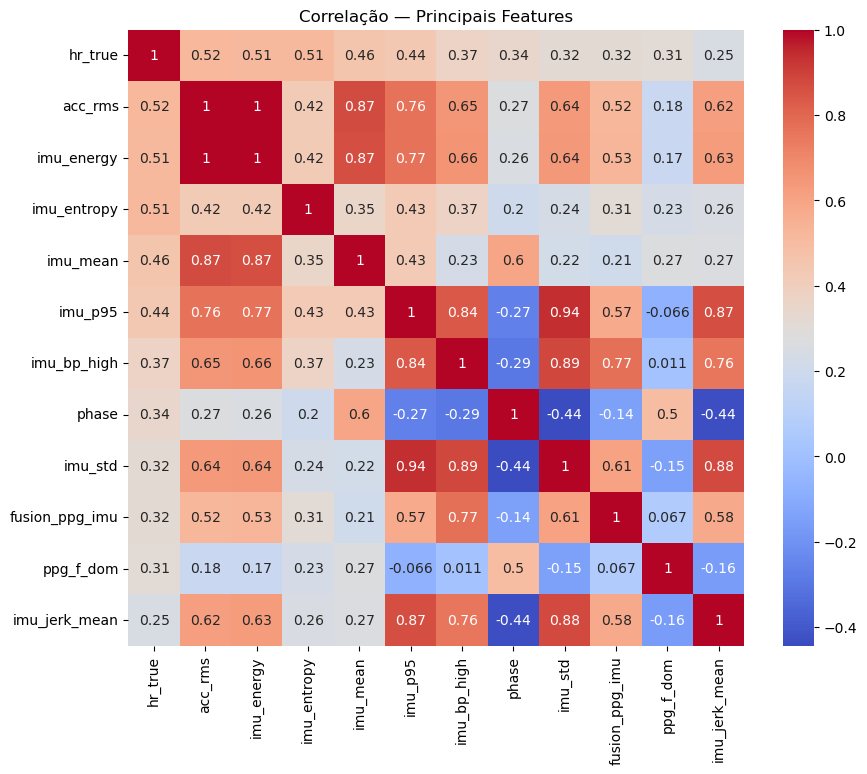


⚙️ Variância explicada (PC1 + PC2): 0.4742198764242548


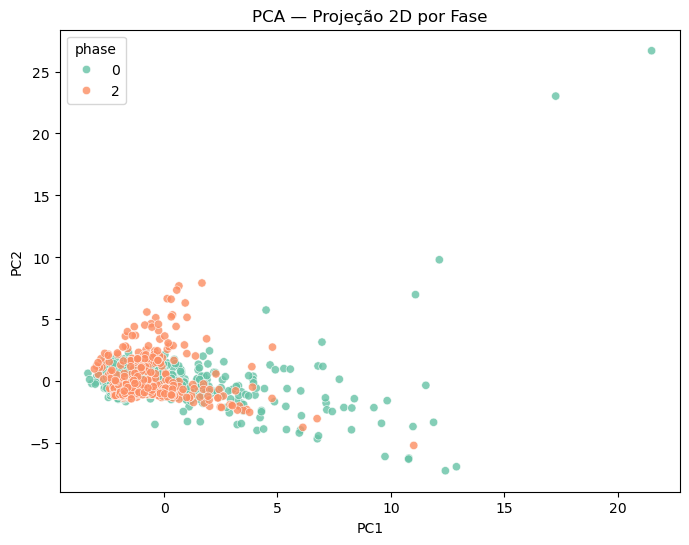


📊 Erro por faixa de movimento:
              mean        std  count
mov_bin                             
low      38.912412  26.651048    264
medium   49.249812  33.849869    264
high     44.404400  34.543786    264


/var/folders/jm/gm4439qn3dd087mjd3q87mgw0000gn/T/ipykernel_1883/1018240541.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby("mov_bin")["hr_err"].agg(["mean","std","count"]))
/var/folders/jm/gm4439qn3dd087mjd3q87mgw0000gn/T/ipykernel_1883/1018240541.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="mov_bin", y="hr_err", palette="Set2")


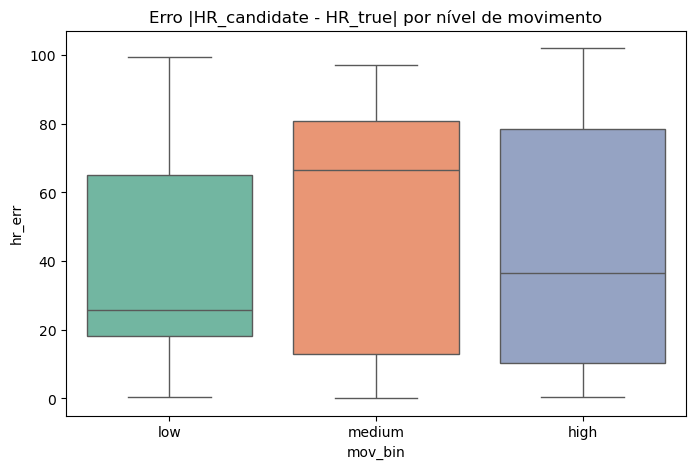


🔗 Correlação movimento ↔ erro HR: -0.05318137685409986

📈 ANOVA — HR_true por fase: F=106.303, p=0.000000
📈 ANOVA — erro por movimento: F=6.948, p=0.001021

📊 SQI Stats:
count    792.000000
mean       0.110629
std        0.096916
min        0.002860
25%        0.043786
50%        0.080128
75%        0.146081
max        0.641165
Name: sqi, dtype: float64

📉 Proporção SQI < 0.5 por fase:
phase
0    0.997475
2    0.992424
Name: low_sqi, dtype: float64


/var/folders/jm/gm4439qn3dd087mjd3q87mgw0000gn/T/ipykernel_1883/1018240541.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups_mov = [g["hr_err"].values for _, g in df.groupby("mov_bin")]


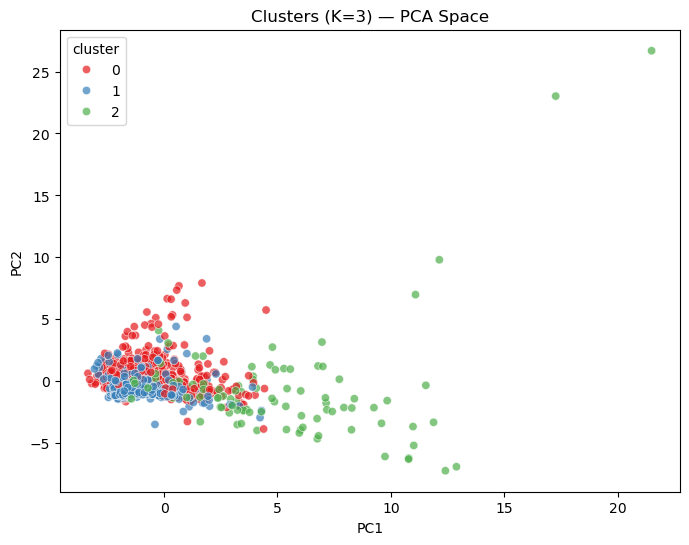


📊 Cluster × Fase:
phase      0    2
cluster          
0        293   98
1         46  259
2         57   39

📊 Cluster × Nível de Movimento:
mov_bin  low  medium  high
cluster                   
0        209     112    70
1         53     142   110
2          2      10    84

=== FASE 4 — COMPLETA ===

💾 Dataset df_all salvo em:
/Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimation/repouso/data/processed/df_all.csv


In [36]:
# ============================================================
# FASE 4 — EDA Estatística Completa
# df_all: saída da FASE 3
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# ============================================================
# 0. Preparação
# ============================================================

df = df_all.copy()

print("=== FASE 4 — EDA ESTATÍSTICA ===")
print(df.shape)
print(df.columns)

# Garantir colunas essenciais
required_cols = ["hr_true", "hr_candidate", "acc_rms", "sqi"]
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Coluna obrigatória está faltando: {c}")

# phase_id numérico para gráficos
df["phase_id"] = df["phase"].astype(int)

# Seleciona apenas features numéricas (exceto identificadores)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in ["Id", "window", "phase_id"]:
    numeric_cols = [c for c in numeric_cols if c != col]


# ============================================================
# 1. Correlações com hr_true
# ============================================================

print("\n📊 Correlações com HR_true (Pearson):")
corr_pearson = df[numeric_cols].corr()["hr_true"].sort_values(ascending=False)
print(corr_pearson.head(15))

print("\n📊 Correlações com HR_true (Spearman):")
corr_spearman = df[numeric_cols].corr(method="spearman")["hr_true"].sort_values(ascending=False)
print(corr_spearman.head(15))

# Heatmap das top features
top_feats = corr_pearson.abs().sort_values(ascending=False).head(12).index.tolist()

plt.figure(figsize=(10,8))
sns.heatmap(df[top_feats].corr(), annot=True, cmap="coolwarm", square=True)
plt.title("Correlação — Principais Features")
plt.show()


# ============================================================
# 2. PCA 2D
# ============================================================

feat_for_pca = [c for c in numeric_cols if c not in ["hr_true", "hr_candidate"]]

X = df[feat_for_pca].values
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)
df["PC1"] = pcs[:,0]
df["PC2"] = pcs[:,1]

print("\n⚙️ Variância explicada (PC1 + PC2):",
      pca.explained_variance_ratio_[:2].sum())

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="PC1", y="PC2", hue="phase", palette="Set2", alpha=0.8)
plt.title("PCA — Projeção 2D por Fase")
plt.show()


# ============================================================
# 3. Erro por nível de movimento
# ============================================================

df["mov_bin"] = pd.qcut(df["acc_rms"], 3, labels=["low","medium","high"])
df["hr_err"] = (df["hr_candidate"] - df["hr_true"]).abs()

print("\n📊 Erro por faixa de movimento:")
print(df.groupby("mov_bin")["hr_err"].agg(["mean","std","count"]))

plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="mov_bin", y="hr_err", palette="Set2")
plt.title("Erro |HR_candidate - HR_true| por nível de movimento")
plt.show()

corr_mov = df[["acc_rms", "hr_err"]].corr().iloc[0,1]
print("\n🔗 Correlação movimento ↔ erro HR:", corr_mov)


# ============================================================
# 4. ANOVA
# ============================================================

groups_phase = [g["hr_true"].values for _, g in df.groupby("phase")]
F_phase, p_phase = stats.f_oneway(*groups_phase)
print(f"\n📈 ANOVA — HR_true por fase: F={F_phase:.3f}, p={p_phase:.6f}")

groups_mov = [g["hr_err"].values for _, g in df.groupby("mov_bin")]
F_mov, p_mov = stats.f_oneway(*groups_mov)
print(f"📈 ANOVA — erro por movimento: F={F_mov:.3f}, p={p_mov:.6f}")


# ============================================================
# 5. Qualidade do dataset (SQI)
# ============================================================

print("\n📊 SQI Stats:")
print(df["sqi"].describe())

df["low_sqi"] = df["sqi"] < 0.5
print("\n📉 Proporção SQI < 0.5 por fase:")
print(df.groupby("phase")["low_sqi"].mean())


# ============================================================
# 6. Clusterização via PCA
# ============================================================

cluster_feats = [
    "hr_true", "hr_candidate", "acc_rms",
    "ppg_std", "sqi", "fusion_ppg_imu"
]
cluster_feats = [f for f in cluster_feats if f in df.columns]

Xc = StandardScaler().fit_transform(df[cluster_feats])

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(Xc)

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="PC1", y="PC2", hue="cluster",
                palette="Set1", alpha=0.7)
plt.title("Clusters (K=3) — PCA Space")
plt.show()

print("\n📊 Cluster × Fase:")
print(pd.crosstab(df["cluster"], df["phase"]))

print("\n📊 Cluster × Nível de Movimento:")
print(pd.crosstab(df["cluster"], df["mov_bin"]))

print("\n=== FASE 4 — COMPLETA ===")


# ============================================================
# 7. Salvar df_all para o pipeline de Feature Engineering
# ============================================================

os.makedirs(PROCESSED_DIR, exist_ok=True)
OUT_FILE = os.path.join(PROCESSED_DIR, "df_all.csv")

df.to_csv(OUT_FILE, index=False)

print("\n💾 Dataset df_all salvo em:")
print(OUT_FILE)

In [16]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 0 to 791
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 792 non-null    int64  
 1   phase              792 non-null    int64  
 2   window             792 non-null    int64  
 3   hr_true            792 non-null    float64
 4   ppg_mean           792 non-null    float64
 5   ppg_std            792 non-null    float64
 6   ppg_min            792 non-null    int32  
 7   ppg_max            792 non-null    int32  
 8   ppg_range          792 non-null    int32  
 9   imu_mean           792 non-null    float64
 10  imu_std            792 non-null    float64
 11  imu_p95            792 non-null    float64
 12  imu_energy         792 non-null    float64
 13  acc_rms            792 non-null    float64
 14  ppg_bp_low         792 non-null    float64
 15  ppg_bp_hr          792 non-null    float64
 16  ppg_bp_high        792 non

## Balance Analysis — Phases 0 and 2

This section evaluates how well-balanced the dataset is across multiple
dimensions before applying feature engineering or oversampling.

**The analysis includes:**

- **Phase distribution:** verifies whether resting phases (0 and 2) contribute similar numbers of windows.
- **Heart rate distribution (binned):** groups `hr_true` into clinically relevant ranges to detect imbalance in low, medium, and high HR segments.
- **Movement intensity distribution:** uses `acc_rms` to categorize windows into *low*, *medium*, and *high* movement levels.
- **Contingency heatmaps:**  
  - Phase × HR bins  
  - Movement × HR bins  
  These reveal whether certain HR ranges or motion levels are overrepresented in a specific phase.
- **Signal Quality Index (SQI):** examines SQI distribution and the percentage of windows with poor signal quality (`SQI < 0.5`).

This balance analysis helps determine whether oversampling or weighting is necessary before training the HR estimation model.

=== BALANCEAMENTO DO DATASET (PHASES 0 E 2) ===
Shape: (792, 29)


/var/folders/jm/gm4439qn3dd087mjd3q87mgw0000gn/T/ipykernel_1883/1617273475.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_bal, x="phase", palette="Set2")


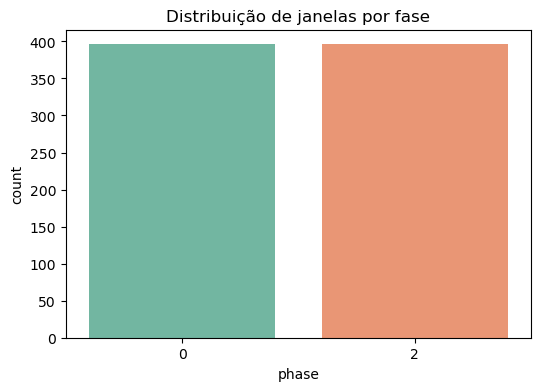


📊 Contagem por fase:
phase
0    396
2    396
Name: count, dtype: int64


/var/folders/jm/gm4439qn3dd087mjd3q87mgw0000gn/T/ipykernel_1883/1617273475.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_bal, x="hr_bin", palette="viridis")


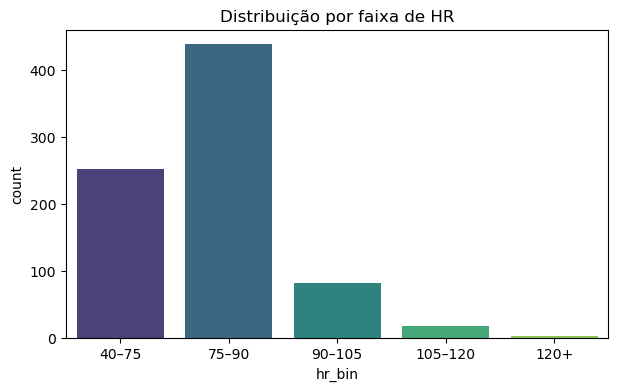


📊 HR bins:
hr_bin
40–75      252
75–90      438
90–105      81
105–120     18
120+         3
Name: count, dtype: int64


/var/folders/jm/gm4439qn3dd087mjd3q87mgw0000gn/T/ipykernel_1883/1617273475.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_bal, x="mov_bin", palette="coolwarm")


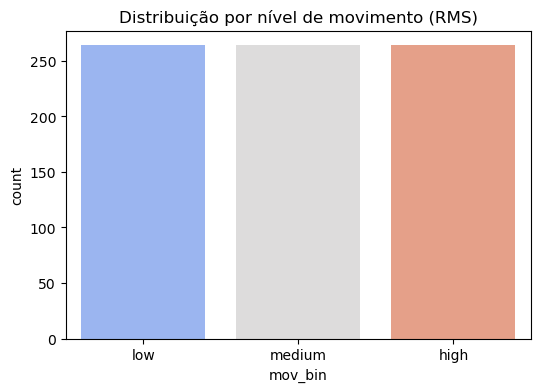


📊 Movimento bins:
mov_bin
low       264
medium    264
high      264
Name: count, dtype: int64


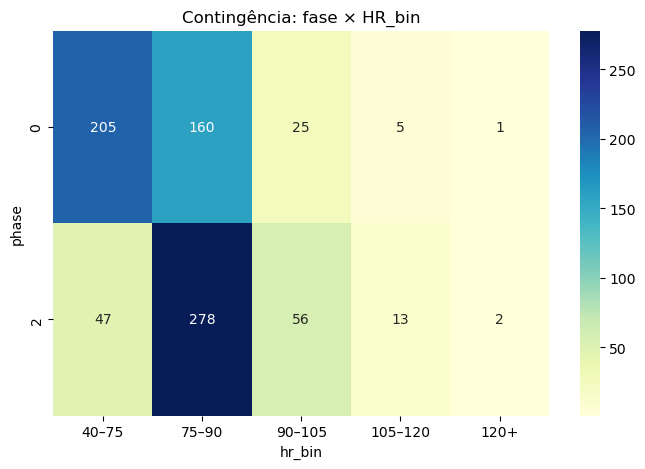


📊 Tabela fase × HR_bin:
hr_bin  40–75  75–90  90–105  105–120  120+
phase                                      
0         205    160      25        5     1
2          47    278      56       13     2


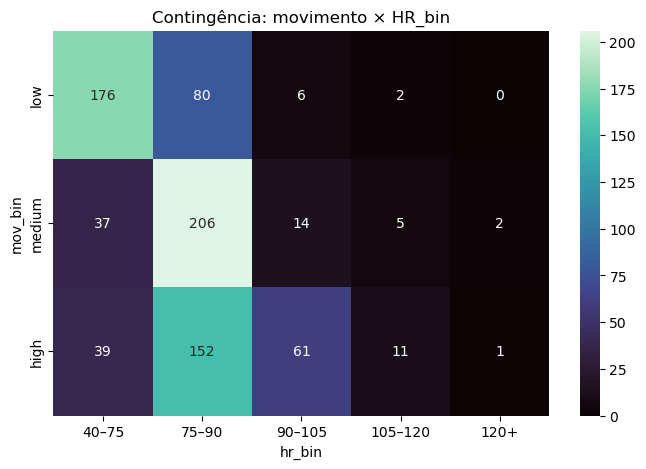


📊 Tabela mov_bin × HR_bin:
hr_bin   40–75  75–90  90–105  105–120  120+
mov_bin                                     
low        176     80       6        2     0
medium      37    206      14        5     2
high        39    152      61       11     1


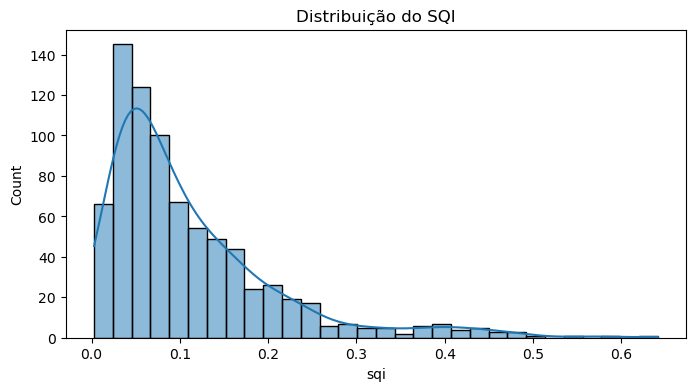


📊 Proporção de SQI baixo (<0.5):
sqi_low
True     0.994949
False    0.005051
Name: proportion, dtype: float64


/var/folders/jm/gm4439qn3dd087mjd3q87mgw0000gn/T/ipykernel_1883/1617273475.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_bal, x="sqi_low", palette="Set1")


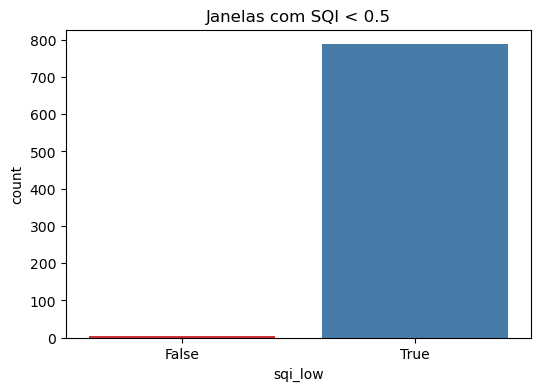

=== FIM DO BALANCEAMENTO ===


In [34]:
# ============================================================
# Análise de Balanceamento (PHASES 0 e 2)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_bal = df_all.copy()

print("=== BALANCEAMENTO DO DATASET (PHASES 0 E 2) ===")
print("Shape:", df_bal.shape)

# ============================================================
# 1. Distribuição por fase
# ============================================================

plt.figure(figsize=(6,4))
sns.countplot(data=df_bal, x="phase", palette="Set2")
plt.title("Distribuição de janelas por fase")
plt.show()

print("\n📊 Contagem por fase:")
print(df_bal["phase"].value_counts())


# ============================================================
# 2. Distribuição de HR por faixas
# ============================================================

bins_hr   = [40, 75, 90, 105, 120, 200]
labels_hr = ["40–75", "75–90", "90–105", "105–120", "120+"]

df_bal["hr_bin"] = pd.cut(
    df_bal["hr_true"],
    bins=bins_hr,
    labels=labels_hr,
    include_lowest=True
)

plt.figure(figsize=(7,4))
sns.countplot(data=df_bal, x="hr_bin", palette="viridis")
plt.title("Distribuição por faixa de HR")
plt.show()

print("\n📊 HR bins:")
print(df_bal["hr_bin"].value_counts().sort_index())


# ============================================================
# 3. Distribuição de movimento (acc_rms)
# ============================================================

df_bal["mov_bin"] = pd.qcut(df_bal["acc_rms"], 3, labels=["low", "medium", "high"])

plt.figure(figsize=(6,4))
sns.countplot(data=df_bal, x="mov_bin", palette="coolwarm")
plt.title("Distribuição por nível de movimento (RMS)")
plt.show()

print("\n📊 Movimento bins:")
print(df_bal["mov_bin"].value_counts())


# ============================================================
# 4. Heatmap — Phase × HR_bin
# ============================================================

ct_phase_hr = pd.crosstab(df_bal["phase"], df_bal["hr_bin"])

plt.figure(figsize=(8,5))
sns.heatmap(ct_phase_hr, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Contingência: fase × HR_bin")
plt.show()

print("\n📊 Tabela fase × HR_bin:")
print(ct_phase_hr)


# ============================================================
# 5. Heatmap — Movimento × HR_bin
# ============================================================

ct_mov_hr = pd.crosstab(df_bal["mov_bin"], df_bal["hr_bin"])

plt.figure(figsize=(8,5))
sns.heatmap(ct_mov_hr, annot=True, fmt="d", cmap="mako")
plt.title("Contingência: movimento × HR_bin")
plt.show()

print("\n📊 Tabela mov_bin × HR_bin:")
print(ct_mov_hr)


# ============================================================
# 6. Distribuição do SQI
# ============================================================

plt.figure(figsize=(8,4))
sns.histplot(df_bal["sqi"], bins=30, kde=True)
plt.title("Distribuição do SQI")
plt.show()

df_bal["sqi_low"] = df_bal["sqi"] < 0.5

print("\n📊 Proporção de SQI baixo (<0.5):")
print(df_bal["sqi_low"].value_counts(normalize=True))

plt.figure(figsize=(6,4))
sns.countplot(data=df_bal, x="sqi_low", palette="Set1")
plt.title("Janelas com SQI < 0.5")
plt.show()

print("=== FIM DO BALANCEAMENTO ===")

## Fim do EDA